# Validation of Navier-Stokes solver against Taylor-Green solution

The Taylor-Green vortex in 2D is an analytical solution to the Navier-Stokes
equation. In primal variables it reads
(https://en.wikipedia.org/wiki/Taylor%E2%80%93Green_vortex#Taylor%E2%80%93Green_vortex_solutiona)

$$
u(x, y, t) = -\cos(x) \sin(y) F(t), \quad v(x, y, t) = \sin(x) \cos(y) F(t),
$$

where $F(t) = \exp(-2\nu t)$.

Hence, the analytical solution for the vorticity is

$$
\omega(x, y, t) = 2 \sin(x) \sin(x) F(t)
$$



In [1]:
import equinox as eqx
import jax.numpy as jnp

In [2]:
import exponax as ex

In [3]:
class TaylorGreenVorticity(eqx.Module):
    nu: float

    def __init__(self, domain_extent, diffusivity):
        if domain_extent != (2 * jnp.pi):
            raise ValueError("Domain extent must be 2 * pi")
        self.nu = diffusivity

    def __call__(self, t, x):
        f_term = jnp.exp(-2 * self.nu * t)
        vorticity = 2 * jnp.sin(x[0:1]) * jnp.sin(x[1:2]) * f_term

        return vorticity

In [4]:
grid = ex.make_grid(2, 2 * jnp.pi, 60)

In [5]:
tg = TaylorGreenVorticity(2 * jnp.pi, 0.1)

In [6]:
ic = tg(0.0, grid)

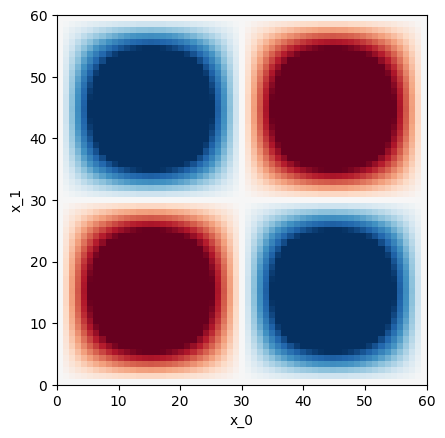

In [7]:
ex.viz.plot_state_2d(ic)

In [8]:
DT = 0.01
ns_stepper = ex.stepper.NavierStokesVorticity(
    2,
    2 * jnp.pi,
    60,
    DT,
    diffusivity=0.1,
)

In [9]:
def rel_error(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

In [10]:
rel_error(ns_stepper(ic), tg(DT, grid))

Array(1.8526086e-07, dtype=float32)

In [11]:
rel_error(ex.repeat(ns_stepper, 10)(ic), tg(10 * DT, grid))

Array(1.06592e-06, dtype=float32)

In [12]:
rel_error(ex.repeat(ns_stepper, 100)(ic), tg(100 * DT, grid))

Array(9.995669e-06, dtype=float32)

In [13]:
rel_error(ex.repeat(ns_stepper, 1000)(ic), tg(1000 * DT, grid))

Array(0.00010065, dtype=float32)